# Stroke Prediction

![](headers/stroke.jpg)

---

### Project Overview 
Stroke is the third leading cause of death in the United States, with over 140,000 people dying annually. Each year approximately 795,000 people suffer from a stroke with nearly 75% of these occuring in people over the age of 65. High blood pressure is the most important risk factor for stroke [(Stroke Center)](http://www.strokecenter.org/patients/about-stroke/stroke-statistics/#:~:text=More%20than%20140%2C000%20people%20die,and%20185%2C000%20are%20recurrent%20attacks.). The goal for this project will be to explore the data and find any correlations between features and the response variable stroke that will allow us to engineer new features for the data. Using these features, we then want to fit a classification model that will be able to predict whether or not a person has had a stroke or not, and in the future to predict the probability of a person having a stroke.

---

#### Data Information
The data originated from the [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) repository for stroke prediction. The following 11 features were recorded for 5110 observations: 

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- `Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke, 0 if not

### Import Libraries / Data

In [1]:
# Import General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools
import time

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
c_map = cm.get_cmap('tab10')

# Import SKLearn Modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split

# Import Statistcs Modules
import statsmodels.api as sm
from imblearn import over_sampling
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

# Data Exploration / Feature Engineering

In [4]:
data.drop('id', axis=1, inplace=True)

In [5]:
data.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [6]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
len(data)

5110

### BMI (Body Mass Index)
The first feature we will want to explore is the BMI, which is also the only feature with missing data. We will want to asses the missing values and fill them with a determined value, as well as remove any outliers.

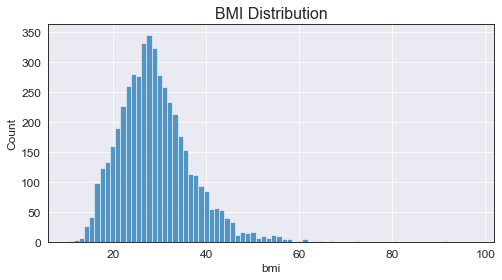

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

In [9]:
# Fill missing with values with median +/- random noises between [1,3]
error_term = np.round(np.sqrt(np.random.randint(1, 9, size=data.bmi.isna().sum())),2)
bmi_fill = data.bmi.median() + error_term

In [10]:
data.loc[data.bmi.isnull(), 'bmi'] = bmi_fill

In [11]:
# Remove any values above the 99th quantile (approx BMI = 53)
data = data[data.bmi < np.quantile(data.bmi, 0.99)]

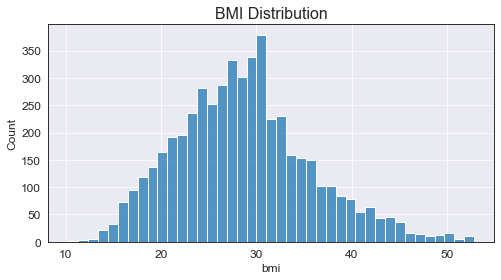

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

We can see now that the distribution of BMI is much more normally distributed with the majority of observations focused around 29.

#### Weight Class (Feature Engineering)
We will now create a new feature using the bmi data, based on the [National Heart, Lung, and Blood Institute BMI Scale](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm). Creating these will allow us the asses the weight for each person in the dataset. The link above gives us the following BMI categories:
- Underweight = Less than 18.5
- Normal weight = 18.5 - 24.9
- Overweight = 25 - 29.9
- Obesity = Greater than 30

In [13]:
# data['obese'] = np.where(data.bmi >= 30, 1, 0)
# data['over_weight'] = np.where(((data.bmi >= 25) & (data.bmi < 30)), 1, 0)
# data['normal_weight'] = np.where(((data.bmi >= 18.5) & (data.bmi < 25)), 1, 0)
# data['under_weight'] = np.where(data.bmi < 18.5, 1, 0)

In [14]:
def weight(row):
    if row['bmi'] >= 30:
        val = 'obese'
    elif ((row['bmi'] >= 25) & (row['bmi'] < 30)):
        val = 'over weight'
    elif ((row['bmi'] >= 18.5) & (row['bmi'] < 25)):
        val = 'normal weight'
    else:
        val = 'under weight'
    return val

data['weight_class'] = data.apply(weight, axis=1)

In [15]:
plt.figure(figsize=(7,5))
sns.countplot(x='weight_class', data=data, palette=sns.color_palette("viridis",4))
plt.title('Weight Distribution')
plt.show();

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='weight_class', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Weight Class')
plt.title('Stroke Distribution by Weight');

In [17]:
data[(data.weight_class == 'under weight') & (data.stroke == 1)]

gender   age  hypertension  heart_disease ever_married      work_type  \
230  Female  81.0             0              0          Yes  Self-employed   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  \
230          Rural              81.95  16.9   never smoked       1   

     weight_class  
230  under weight

In [18]:
# Weight class age distribution
data.groupby('weight_class').agg(['min', 'mean', 'max'])['age']

min       mean   max
weight_class                        
normal weight  0.24  33.756267  82.0
obese          0.48  50.065944  82.0
over weight    1.32  49.264011  82.0
under weight   0.08  10.908843  82.0

It seems that the majority of the people observed in this dataset were either over weight or obese. Similarly, looking at the occurance of strokes for each class it seems that these two weight classes have the majority of the strokes as well. People who are underweight seemed to have close to 0 strokes, but looking further into the data for this weight class we can see that the majority of people in this weight class are around the age 11 (children), with the only person having stroke being 81.

### Age & Other Numerical Features
We now will explore the remaining numerical features in our dataset. We will want to see the distribution for age and average glucose levels, as well as seeing the correlation between hypertension and heart disease on having a stroke. In general, we will use the following variables:
- 0 - denotes not having a disease
- 1 - denotes having the disease

In [19]:
plt.figure(figsize=(7,4))
sns.histplot(x="age", data=data)
plt.title('Age Distribution')
plt.show();

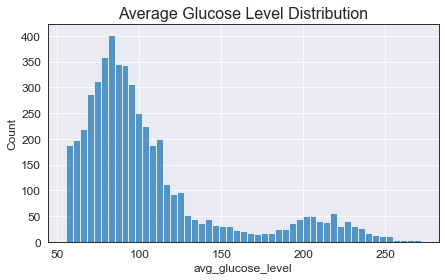

In [20]:
plt.figure(figsize=(7,4))
sns.histplot(x="avg_glucose_level", data=data)
plt.title('Average Glucose Level Distribution')
plt.show();

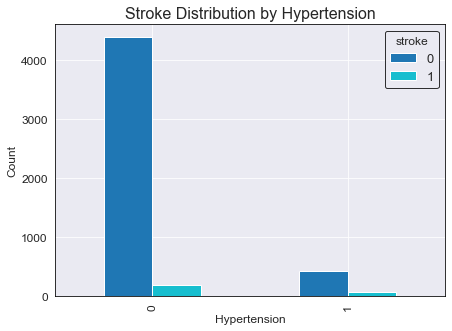

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
data.pivot_table(index='hypertension', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Hypertension')
plt.title('Stroke Distribution by Hypertension');

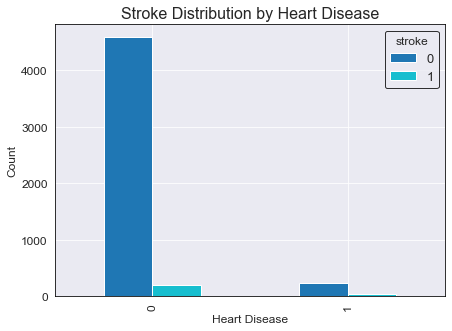

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))
data.pivot_table(index='heart_disease', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Heart Disease')
plt.title('Stroke Distribution by Heart Disease');

Age does not seem to have a certain type of distribution (closest to a uniform distribution). Average Glucose seems to have a right skew, with a slight increase in the 180-220 range. For both hypertension and heart disease, people who do not have the disease were more likely to have a stroke. Similarly, we can see that both have the majority of their data being 0 (no disease), so we can't be sure too if no disease means less chance of stroke (maybe just less observations?).

#### Age Group (Feature Engineering)
Using the [Age Categories](https://www.statcan.gc.ca/eng/concepts/definitions/age2) from the Canadian Statistics website, we will create features for the life cycle groupings defined on their website:
- Children (0-14)
- Youth (15-24)
- Adults (25-64)
- Seniors (65+)

In [26]:
data['child'] = np.where(data.age < 15, 1, 0)
data['youth'] = np.where(((data.age >= 15) & (data.age < 25)), 1, 0)
data['adult'] = np.where(((data.age >= 25) & (data.age < 65)), 1, 0)
data['senior'] = np.where(data.age > 65, 1, 0)

In [27]:
def age(row):
    if row['child'] == 1:
        val = 'child'
    elif row['youth'] == 1:
        val = 'youth'
    elif row['adult'] == 1:
        val = 'adult'
    else:
        val = 'senior'
    return val

data['age_class'] = data.apply(age, axis=1)

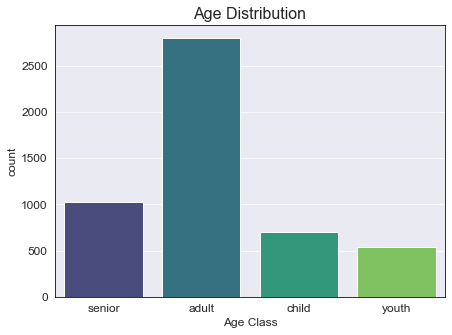

In [28]:
plt.figure(figsize=(7,5))
sns.countplot(x='age_class', data=data, palette=sns.color_palette("viridis",4))
plt.title('Age Distribution')
plt.xlabel('Age Class')
plt.show();

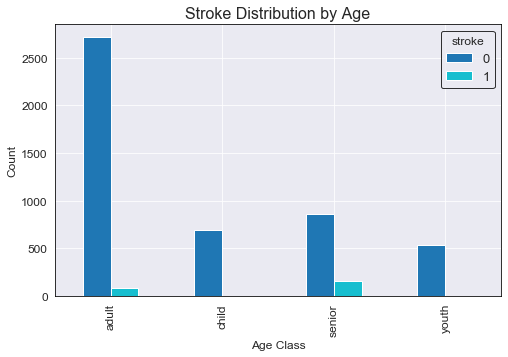

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='age_class', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.title('Stroke Distribution by Age');

In [30]:
data[((data.age_class == 'child') | (data.age_class == 'youth')) 
     & (data.stroke == 1)][['gender', 'age', 'bmi', 'weight_class','stroke']]

gender    age   bmi weight_class  stroke
162  Female   1.32  29.1  over weight       1
245  Female  14.00  30.9        obese       1

It seems that the majority of the people observed in the data were adults (25-64). However, people categorized as seniors had the highest amount of strokes. It also looks like both children and youth have very low stroke rates, and looking into this further we can see only two female children (age 1 and 14) had strokes. An important note is that the two children who had strokes were both cateogirzed as obese with a BMI of approximately 30 for both. 

### Smoking Status, Gender, and Marriage
The remaining features we want to explore do not require any feature engineering with them as they are all categorical variables. We will want to explore the correlation between them and having a stroke in order to determine if we want to keep or drop them for the final model.

In [31]:
def stroke_ratio(feature):
    '''
    Create a pivot table for the number of strokes relative to the observations
    for a given feature. Ratio is returned as a percentage of the total subgroup
    that had a stroke.
    '''
    data_pivot = data.pivot_table(index=feature, columns='stroke', aggfunc='size')
    data_pivot['Ratio'] = round(data_pivot[1]/data_pivot[0], 4)*100
    return data_pivot.iloc[:,-1:]

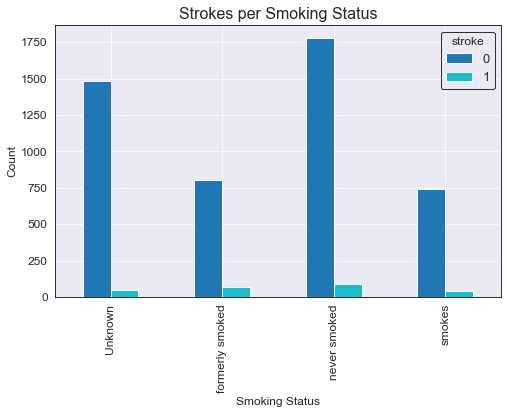

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='smoking_status', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Smoking Status')
plt.title('Strokes per Smoking Status');

In [33]:
stroke_ratio('smoking_status')

stroke           Ratio
smoking_status        
Unknown           3.16
formerly smoked   8.68
never smoked      5.00
smokes            5.68

There does not seem to be a clear distinction in which smoking status is linked to the highest likelihood of having a stroke, but people who have never smoked have had more strokes than people who do smoke (although looking at the ratio's found above, we can see people who smoke or previously smoked have had the most strokes in repsect to the subgroups).

In [34]:
data = data[data.gender != 'Other'] # remove gender = "Other" (only 1 obseration, done to simplify feature)

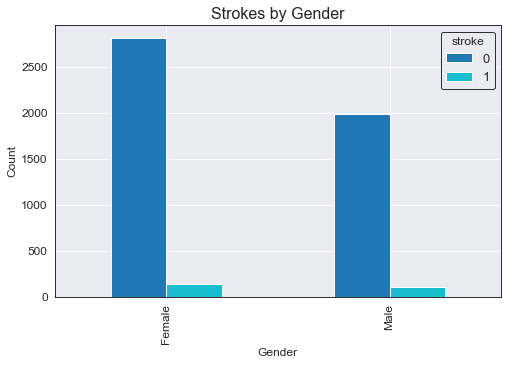

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='gender', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Strokes by Gender');

In [36]:
stroke_ratio('gender')

stroke  Ratio
gender       
Female   4.97
Male     5.42

We seem to have around 800 more females than males in our dataset, but the amount of strokes for each gender seem to be about equivalent. Similarly, their ratio in repsect to their group total are about equivalent.

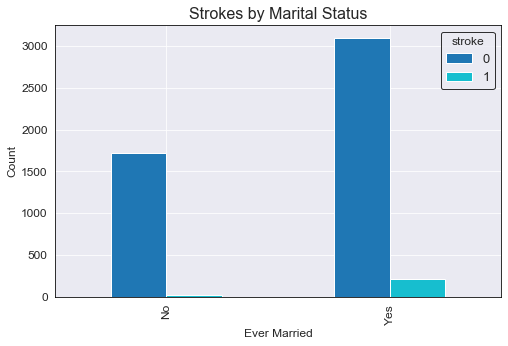

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='ever_married', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Ever Married')
plt.title('Strokes by Marital Status');

In [38]:
stroke_ratio('ever_married')

stroke        Ratio
ever_married       
No             1.69
Yes            7.08

We have about two times as many observations of people who have been married compared to those who have not. Similarly, looking at the ratios we can see than being married seems to have around 4x more strokes than never being married.

#### Remaining Categorical Features

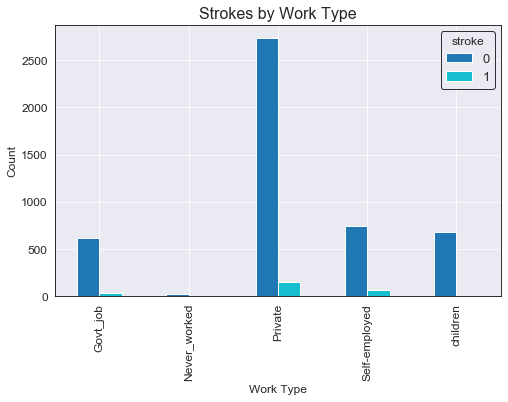

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='work_type', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Work Type')
plt.title('Strokes by Work Type');

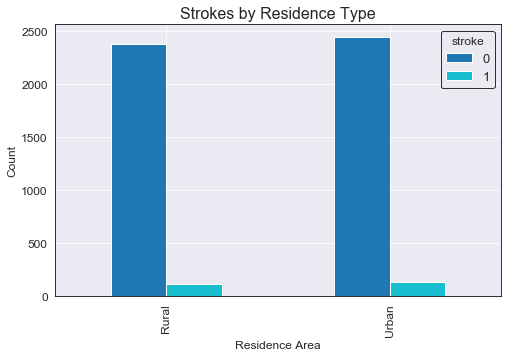

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))
data.pivot_table(index='Residence_type', columns='stroke', aggfunc='size').plot(kind='bar', ax=ax, colormap=c_map);
plt.ylabel('Count')
plt.xlabel('Residence Area')
plt.title('Strokes by Residence Type');

Looking at the final two features, there does not seem to be a correlation between work or residence type with stroke. Private work seems to have the higest stroke count, but it also takes up the majority of observations. Residence type seem to be almost even between both types, so there is not much that would be useful in our model here.

# Data Preprocessing
Now that we have explored the data and created new features, we can begin to format the data so that it is in the format our model will need. We will want to:
- Drop all features that won't be used
- One-Hot-Encode categorical features (gender, ever_married, smoking_status)
- Plot correlation matrix for features kept for model (assess any features that should be dropped)

In [41]:
len(data) # original data had length 5110

5057

In [42]:
# Drop features that wont be used
data.drop(['work_type', 'Residence_type', 'age_class', 'ever_married'], axis=1, inplace=True)

In [43]:
data.head() # see current form of data (17 features)

gender   age  hypertension  heart_disease  avg_glucose_level    bmi  \
0    Male  67.0             0              1             228.69  36.60   
1  Female  61.0             0              0             202.21  30.34   
2    Male  80.0             0              1             105.92  32.50   
3  Female  49.0             0              0             171.23  34.40   
4  Female  79.0             1              0             174.12  24.00   

    smoking_status  stroke   weight_class  child  youth  adult  senior  
0  formerly smoked       1          obese      0      0      0       1  
1     never smoked       1          obese      0      0      1       0  
2     never smoked       1          obese      0      0      0       1  
3           smokes       1          obese      0      0      1       0  
4     never smoked       1  normal weight      0      0      0       1

In [44]:
data['gender'] = data['gender'].replace(['Male', 'Female'], [1,2])
data['weight_class'] = data['weight_class'].replace(['obese', 'over weight', 'normal weight', 'under weight'], [4,3,2,1])
data['ever_smoked'] = np.where(((data.smoking_status == 'formerly smoked') | (data.smoking_status == 'smokes')), 1, 0)
data['never_smoked'] = np.where((data.smoking_status == 'never smoked'), 1, 0)
data.drop(['smoking_status'], axis=1, inplace=True)

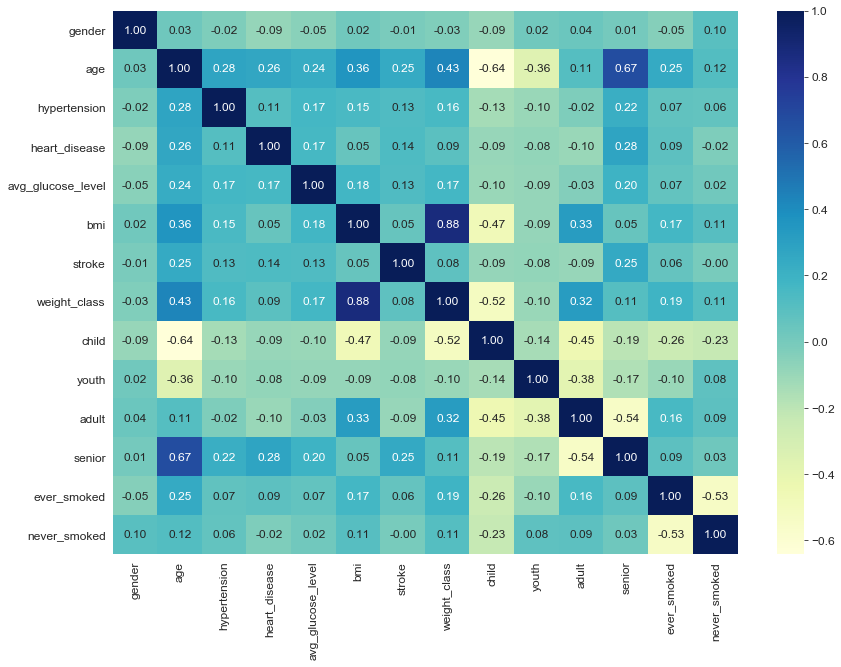

In [46]:
corr_matrix = data.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu')
plt.show();

Looking at the above matrix it seems that stroke has the highest correlation with the following features: senior (0.25), age (0.25), heart_disease (0.14), hyptertension (0.13), and avg_glucose_level (0.13). There are other features that are correlated with stroke that we engineered, but are lower than the ones listed previously. Now that our data is scaled and a subset of the features are kept, we can begin the modeling section. We also will want to save our data to use later so we do not have to keep re-running the notebook.

In [47]:
data.to_csv('stroke_data_processed.csv', index=False)

# Modeling

In [48]:
data = pd.read_csv('stroke_data_processed.csv')
data.head()

gender   age  hypertension  heart_disease  avg_glucose_level    bmi  \
0       1  67.0             0              1             228.69  36.60   
1       2  61.0             0              0             202.21  30.34   
2       1  80.0             0              1             105.92  32.50   
3       2  49.0             0              0             171.23  34.40   
4       2  79.0             1              0             174.12  24.00   

   stroke  weight_class  child  youth  adult  senior  ever_smoked  \
0       1             4      0      0      0       1            1   
1       1             4      0      0      1       0            0   
2       1             4      0      0      0       1            0   
3       1             4      0      0      1       0            1   
4       1             2      0      0      0       1            0   

   never_smoked  
0             0  
1             1  
2             1  
3             0  
4             1

In [49]:
X = data.drop('stroke', axis=1)
y = data['stroke'].values

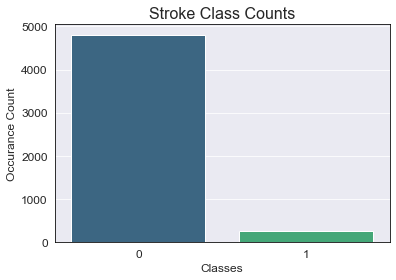

In [50]:
plt.figure(figsize=(6,4))
sns.countplot(y, palette=sns.color_palette("viridis",2))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Stroke Class Counts')
plt.show();

## Base Model
We will begin by seeing what the base accuracy for our model would be if we were to assign 0 to all observations. We can see a clear class imbalance in the above graph (around 15x more **0** observations than **1**). Knowing this, we will need to take into account more than just the accuracy score for evaluating our model.

In [51]:
zeros_preds = np.zeros(len(data))
print(classification_report(y, zeros_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4809
           1       0.00      0.00      0.00       248

    accuracy                           0.95      5057
   macro avg       0.48      0.50      0.49      5057
weighted avg       0.90      0.95      0.93      5057



In [52]:
ones_preds = np.ones(len(data))
print(classification_report(y, ones_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4809
           1       0.05      1.00      0.09       248

    accuracy                           0.05      5057
   macro avg       0.02      0.50      0.05      5057
weighted avg       0.00      0.05      0.00      5057



In [53]:
def plot_confusion_matrix(true_labels, y_preds, title):
    '''
    Plot an annotated confusion matrix to visualize the evaluation for
    our model predictions. Includes error labels and counts.
    '''
    cf_matrix = confusion_matrix(true_labels, y_preds)
    counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = [f'{label}\n{count}' for label,count in zip(labels, counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,4))
    sns.heatmap(cf_matrix, fmt='', annot=labels, cmap='Reds')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show();
    return None

*Note: Idea for this function came from this [Medium Article](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea) by Dennis T. on visualizing confusion matricies.*

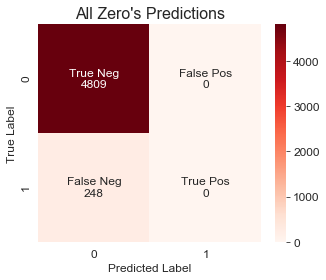

In [54]:
plot_confusion_matrix(y, zeros_preds, 'All Zero\'s Predictions')

In [55]:
plot_confusion_matrix(y, ones_preds, 'All One\'s Predictions')

#### Evaluation Metric Setup
From assigning a predicted value of 0 for all observations, we can see our base model accuracy is around 95%. This indicates we will need a higher accuracy score in order for our model to be performing well. However, the main focus that we can see that we want to focus on avoiding *False Negatives* in our model, where we estimate no stroke when the patient had a stroke. We can interpret the following from the findings above:
- Using **Recall** as an evaluation metric will be extremely useful to avoid false negatives (all one's above had recall = 1, all zero's had recall = 0).
- We will also want to take into consideration *False Positives* (**precision**) so that we are not classifying strokes for people who have not had one. 
- Using a $F_{\beta}$ score focused more on recall (larger $\beta$ value) could also be useful.
- Accuracy will not be a key factor in the evaulation of our model (high accuracy can be acheived with base model).

## Statistical Modeling

Using [StatsModels](https://www.statsmodels.org/v0.10.1/), we will fit a Logistic Model on the processed stroke dataset. Knowing that we have a class imbalance from above, we will want to use **SMOTE** (Synthetic Minority Oversampling Technique) in order to sample from the Stroke class and balance our observations (currently, there is around 20x more "No Stroke" compared to "Stroke".

Note that we first split the data into training and testing sets before sampling in order to avoid having sampled observations for the minority class to appear in both the train and test sets, leading to the model overfitting since it would have already seen the exact observation it is predicting on.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sampler = over_sampling.SMOTE(sampling_strategy=0.75)
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)

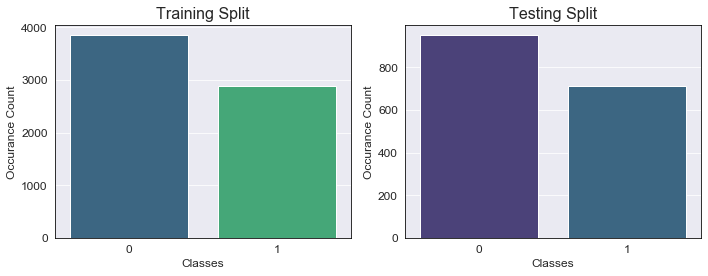

In [57]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
sns.countplot(y_train, palette=sns.color_palette("viridis",2))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Training Split')
ax2 = plt.subplot(1,2,2)
sns.countplot(y_test, palette=sns.color_palette("viridis",5))
plt.xlabel('Classes')
plt.ylabel('Occurance Count')
plt.title('Testing Split')
plt.tight_layout()
plt.show();

Using a sampling strategy value of 0.75, we sampled the "stroke" class so the total number of observations for 'stroke' (1) would be 75% of the number of total observations for 'no stroke' (0). Now that our classes are more balanced, the model can be fitted.

In [58]:
# Create data frame for GLM model (X_train & y_train in same data frame)
data_glm = X_train.copy()
data_glm['stroke'] = y_train

In [60]:
# Fit with all variables
response_var = 'stroke ~ '
explanatory_vars = ' + '.join(X_train.columns.values)
formula1 = response_var + explanatory_vars
formula1

'stroke ~ gender + age + hypertension + heart_disease + avg_glucose_level + bmi + weight_class + child + youth + adult + senior + ever_smoked + never_smoked'

In [61]:
# Fit with top 8 correlated features with stroke from data frame
top_corr_feats = abs(data_glm.corr()['stroke']).sort_values(ascending=False)[1:9].index.values
response_var = 'stroke ~ '
explanatory_vars = ' + '.join(top_corr_feats)
formula2 = response_var + explanatory_vars
formula2

'stroke ~ age + senior + adult + avg_glucose_level + gender + child + youth + never_smoked'

In [66]:
model = sm.GLM.from_formula(formula1, family=sm.families.Binomial(), data=data_glm)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 6749
Model:                            GLM   Df Residuals:                     6735
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2479.3
Date:                Sat, 06 Mar 2021   Deviance:                       4958.6
Time:                        12:35:04   Pearson chi2:                 7.06e+03
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.7964      0.427     -4.210      0.000      -2.633      -0.960
gender               -1.1150      0.074    -15.098      0.000      -1.260      -0.970
age                   0.0911      0.005     18.323      0.000       0.081       0.101
hypertension         -0.4677      0.114     -4.087      0.000      -0.692      -0.243
heart_disease        -1.0078      0.149     -6.758      0.000      -1.300      -0.716
avg_glucose_level     0.0054      0.001      7.789      0.000       0.004       0.007
bmi                   0.0863      0.011      7.826      0.000       0.065       0.108
weight_class         -0.8083      0.082     -9.802      0.000      -0.970      -0.647
child                -2.2604      0.472     -4.790      0.000      -3.185      -1.335
youth               -24.5413   1.55e+04     -0.002      0.999   -3.03e+04    3.03e+04
adult                -1.5085      0.196     -7.680      0.000      -1.893      -1.124
senior               -1.8630      0.207     -9.014      0.000      -2.268      -1.458
ever_smoked          -1.8529      0.090    -20.685      0.000      -2.029      -1.677
never_smoked         -1.8124      0.090    -20.195      0.000      -1.988      -1.637
=====================================================================================
"""

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       952
           1       0.80      0.77      0.78       714

    accuracy                           0.82      1666
   macro avg       0.82      0.81      0.81      1666
weighted avg       0.82      0.82      0.82      1666



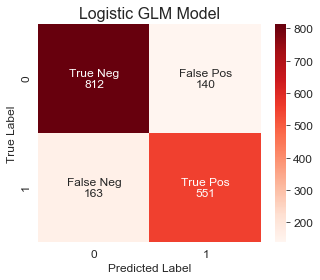

In [67]:
y_preds = round(result.predict(X_test))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Logistic GLM Model')

*Evaluate performance...*

### Feature Subset Selection

*Citation: Idea came from the [Lab 8](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html) notebook from Smith College on subset selection in Python with StatsModels. The labe code was adapated to use different evaluations and modeling for this notebook.*

#### Forward Stepwise Feature Selection

In [71]:
data_glm

gender        age  hypertension  heart_disease  avg_glucose_level  \
0          1  54.000000             0              0         114.610000   
1          2  11.000000             0              0         107.180000   
2          1  71.000000             0              1          70.710000   
3          1  11.000000             0              0          96.910000   
4          1  59.000000             0              0          86.230000   
...      ...        ...           ...            ...                ...   
6744       2  76.208939             0              0         199.586860   
6745       1  77.942462             0              0         105.526180   
6746       1  78.958725             0              0         137.220782   
6747       1  76.089953             0              0          98.328465   
6748       2  51.693051             0              0          97.444854   

            bmi  weight_class  child  youth  adult  senior  ever_smoked  \
0     40.100000             4      0      0      1       0            1   
1     27.600000             3      1      0      0       0            0   
2     30.100000             4      0      0      0       1            0   
3     20.400000             2      1      0      0       0            0   
4     30.000000             4      0      0      1       0            1   
...         ...           ...    ...    ...    ...     ...          ...   
6744  27.446257             3      0      0      0       1            0   
6745  27.772651             3      0      0      0       1            0   
6746  31.874294             3      0      0      0       1            0   
6747  24.220631             2      0      0      0       1            0   
6748  27.167373             3      0      0      1       0            0   

      never_smoked  stroke  
0                0       0  
1                0       0  
2                1       0  
3                0       0  
4                0       1  
...            ...     ...  
6744             0       1  
6745             0       1  
6746             0       1  
6747             0       1  
6748             0       1  

[6749 rows x 14 columns]

In [68]:
def fitModel(feature_subset):
    response_var = 'stroke ~ '
    explanatory_vars = ' + '.join(X_train[list(feature_subset)].columns.values)
    formula = response_var + explanatory_vars
    model = sm.GLM.from_formula(formula, family=sm.families.Binomial(), data=data_glm)
    result = model.fit()
    y_preds = round(result.predict(X_test[list(feature_subset)]))
    model_acc = accuracy_score(y_test, y_preds)
    model_fbeta = fbeta_score(y_test, y_preds, beta=0.5)
    return {'model': result, 'bic': result.bic, 'accuracy': model_acc, 
            'fbeta': model_fbeta, 'features' :X_train[list(feature_subset)].columns.values}

def forwardSelection(predictors):
    start = time.time()
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(fitModel(predictors+[p]))
    
    models = pd.DataFrame(results)
    best_model = models.sort_values(by='fbeta', ascending=False).iloc[0,:]
    print("Processed", models.shape[0], "models on", len(predictors)+1, "predictors in", round(time.time()-start,3), "seconds.")
    
    return best_model.values

In [75]:
models_fwd = pd.DataFrame(columns=["Model", "BIC", "Accuracy", "FBeta (0.5)", "Features"])
predictors = []

for i in range(1,len(data_glm.columns)):
    models_fwd.loc[i] = forwardSelection(predictors)
    predictors = models_fwd.loc[i]["Model"].model.exog_names[1:]

Processed 13 models on 1 predictors in 0.283 seconds.
Processed 12 models on 2 predictors in 0.335 seconds.
Processed 11 models on 3 predictors in 0.315 seconds.
Processed 10 models on 4 predictors in 0.349 seconds.
Processed 9 models on 5 predictors in 0.361 seconds.
Processed 8 models on 6 predictors in 0.327 seconds.
Processed 7 models on 7 predictors in 0.326 seconds.
Processed 6 models on 8 predictors in 0.342 seconds.
Processed 5 models on 9 predictors in 0.275 seconds.
Processed 4 models on 10 predictors in 0.264 seconds.
Processed 3 models on 11 predictors in 0.321 seconds.
Processed 2 models on 12 predictors in 0.235 seconds.
Processed 1 models on 13 predictors in 0.117 seconds.


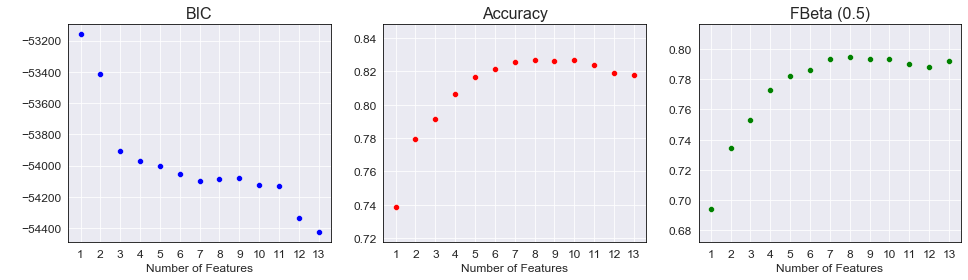

In [76]:
# Plot results from forward selection above
plt.figure(figsize=(16,4))
xticks = np.arange(1,len(models_fwd)+1)
colors = ['blue', 'red', 'green']
for idx in range(1,4):
    ax = plt.subplot(1,3,idx)
    sns.scatterplot(x=xticks, y=models_fwd.iloc[:, idx], color=colors[idx-1])
    plt.xlabel('Number of Features')
    plt.title(f'{models_fwd.columns[idx]}')
    plt.ylabel(' ')
    plt.xticks(xticks)
plt.show()

*Results here...*

In [79]:
models_fwd.loc[10]['Model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 6749
Model:                            GLM   Df Residuals:                     6738
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2643.1
Date:                Sat, 06 Mar 2021   Deviance:                       5286.2
Time:                        12:40:08   Pearson chi2:                 6.05e+03
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.5251      0.396     -8.895      0.000      -4.302      -2.748
age                   0.0932      0.005     19.367      0.000       0.084       0.103
never_smoked         -1.9253      0.086    -22.331      0.000      -2.094      -1.756
ever_smoked          -1.7987      0.085    -21.169      0.000      -1.965      -1.632
senior               -1.9139      0.199     -9.599      0.000      -2.305      -1.523
adult                -1.5084      0.189     -7.969      0.000      -1.879      -1.137
avg_glucose_level     0.0052      0.001      7.836      0.000       0.004       0.007
heart_disease        -0.9908      0.144     -6.886      0.000      -1.273      -0.709
bmi               -3.041e-05      0.007     -0.005      0.996      -0.013       0.013
child                -1.6864      0.462     -3.651      0.000      -2.592      -0.781
youth               -24.3258   1.58e+04     -0.002      0.999   -3.11e+04     3.1e+04
=====================================================================================
"""

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       952
           1       0.79      0.82      0.80       714

    accuracy                           0.83      1666
   macro avg       0.82      0.83      0.82      1666
weighted avg       0.83      0.83      0.83      1666



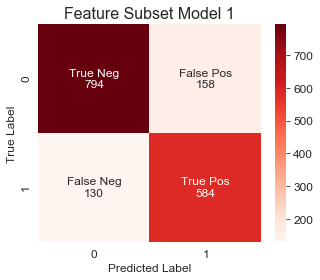

In [85]:
result = models_fwd.loc[10]['Model']
y_preds = round(result.predict(X_test[models_fwd.loc[10]['Features']]))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Feature Subset Model 1')

#### Exhaustive Subset Feature Selection

In [80]:
def exhaustiveSearch(k):
    start = time.time()
    results = []
    
    for combo in itertools.combinations(X_train, k):
        results.append(fitModel(combo))
    
    models = pd.DataFrame(results)
    best_model = models.sort_values(by='fbeta', ascending=False).iloc[0,:]
    print("Processed", models.shape[0], "models on", k, "predictors in", round(time.time()-start,3), "seconds.")
    
    return best_model.values

In [81]:
models_exhaust = pd.DataFrame(columns=["Model", "BIC", "Accuracy", "FBeta (0.5)", "Features"])

for i in range(1,11):
    models_exhaust.loc[i] = exhaustiveSearch(i)

Processed 13 models on 1 predictors in 0.271 seconds.
Processed 78 models on 2 predictors in 2.106 seconds.
Processed 286 models on 3 predictors in 9.459 seconds.
Processed 715 models on 4 predictors in 30.037 seconds.
Processed 1287 models on 5 predictors in 73.312 seconds.
Processed 1716 models on 6 predictors in 122.185 seconds.
Processed 1716 models on 7 predictors in 141.33 seconds.
Processed 1287 models on 8 predictors in 102.357 seconds.
Processed 715 models on 9 predictors in 60.978 seconds.
Processed 286 models on 10 predictors in 25.881 seconds.


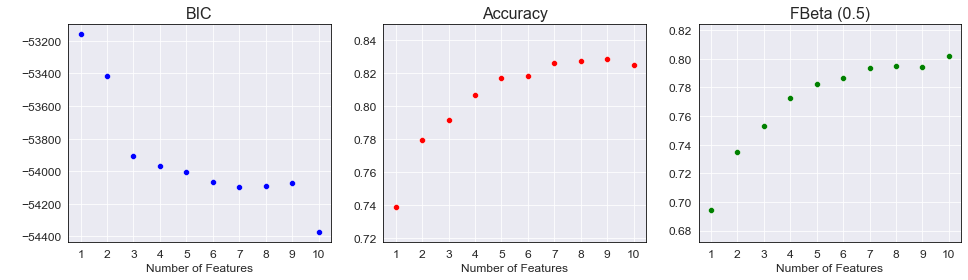

In [82]:
# Plot results from exhaustive selection above
plt.figure(figsize=(16,4))
xticks = np.arange(1,11)
colors = ['blue', 'red', 'green']
for idx in range(1,4):
    ax = plt.subplot(1,3,idx)
    sns.scatterplot(x=xticks, y=models_exhaust.iloc[:, idx], color=colors[idx-1])
    plt.xlabel('Number of Features')
    plt.title(f'{models_exhaust.columns[idx]}')
    plt.ylabel(' ')
    plt.xticks(xticks)
plt.show()

In [83]:
models_exhaust.loc[10]['Model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 6749
Model:                            GLM   Df Residuals:                     6738
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2518.8
Date:                Sat, 06 Mar 2021   Deviance:                       5037.5
Time:                        12:50:10   Pearson chi2:                 7.13e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.8741      0.276    -14.058      0.000      -4.414      -3.334
gender               -1.0758      0.073    -14.710      0.000      -1.219      -0.932
age                   0.1131      0.004     28.736      0.000       0.105       0.121
heart_disease        -1.0256      0.146     -7.015      0.000      -1.312      -0.739
avg_glucose_level     0.0051      0.001      7.434      0.000       0.004       0.006
bmi                   0.0904      0.011      8.274      0.000       0.069       0.112
weight_class         -0.8098      0.082     -9.866      0.000      -0.971      -0.649
adult                -0.7384      0.144     -5.142      0.000      -1.020      -0.457
senior               -1.6213      0.187     -8.676      0.000      -1.988      -1.255
ever_smoked          -1.8775      0.089    -21.001      0.000      -2.053      -1.702
never_smoked         -1.8650      0.089    -20.849      0.000      -2.040      -1.690
=====================================================================================
"""

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       952
           1       0.81      0.77      0.79       714

    accuracy                           0.82      1666
   macro avg       0.82      0.82      0.82      1666
weighted avg       0.82      0.82      0.82      1666



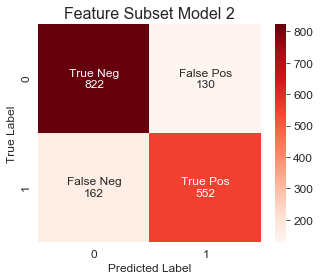

In [86]:
result = models_exhaust.loc[10]['Model']
y_preds = round(result.predict(X_test[models_exhaust.loc[10]['Features']]))
print(classification_report(y_test, y_preds))
plot_confusion_matrix(y_test, y_preds, 'Feature Subset Model 2')

## Ensemble Modeling